In [126]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
%matplotlib inline

data = pd.read_csv("./data/used_car_train_20200313_revised.csv")
data_test = pd.read_csv("./data/used_car_testA_20200313_revised.csv")
data['notRepairedDamage'].replace(to_replace='-', value='NaN', inplace=True)
data['notRepairedDamage'] = data['notRepairedDamage'].astype('float64')
data_test['notRepairedDamage'].replace(to_replace='-', value='NaN', inplace=True)
data['notRepairedDamage'] = data['notRepairedDamage'].astype('float64')


In [56]:
ft_y_dict = {} # - xi-y tables, key: column name
keys = data.columns
keys = keys.drop(['price','SaleID'])
for col in keys:
    ft_y_df = data[['SaleID', col, 'price']].set_index('SaleID')
    ft_y_dict[col] = ft_y_df.sort_values(by=col)
    
def sampled(ft_y_df, num=15000):
    sample_indices = [int(i) for i in np.linspace(0, len(ft_y_df)-1, num=num)]
    return ft_y_df.iloc[sample_indices]

def sampled_dict(ft_y_dict, num=15000):
    for k, v in ft_y_dict.items():
        ft_y_dict[k] = sampled(v)
    return ft_y_dict

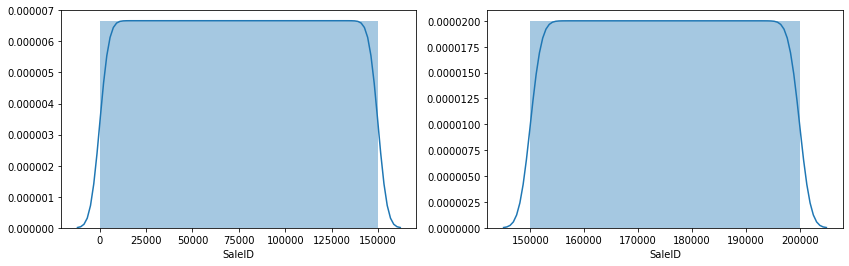

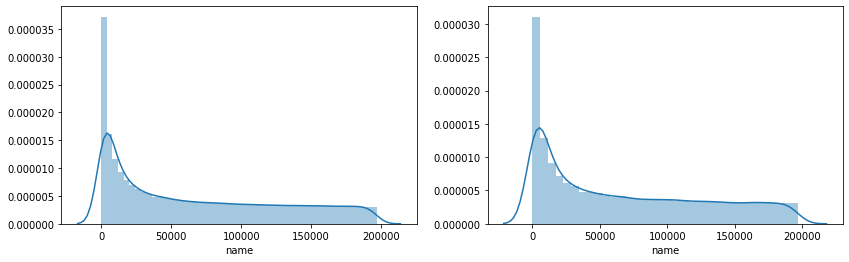

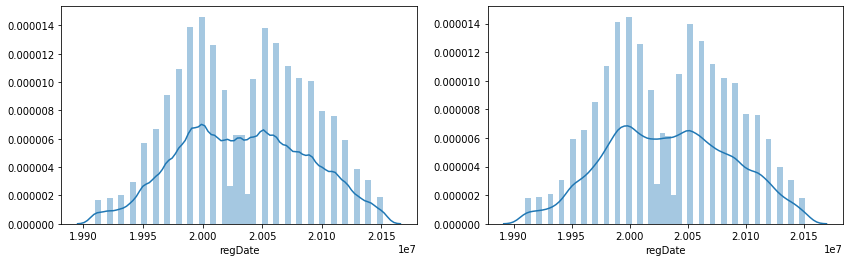

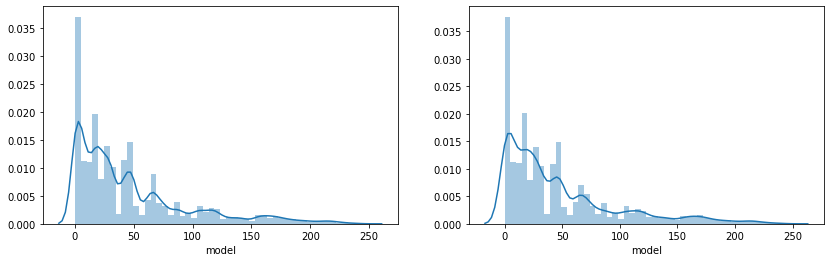

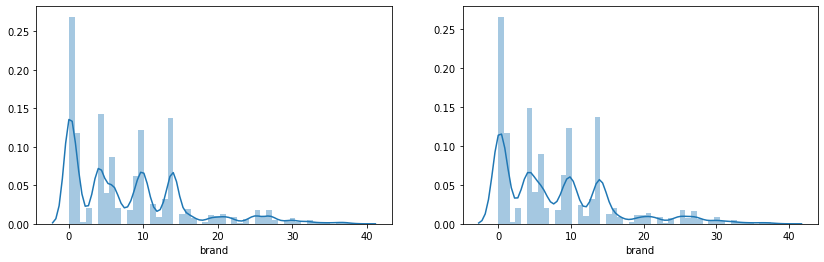

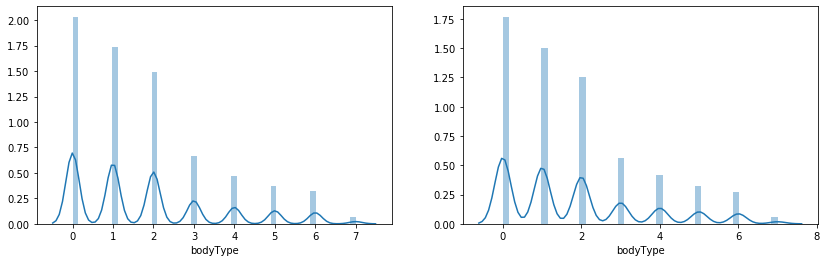

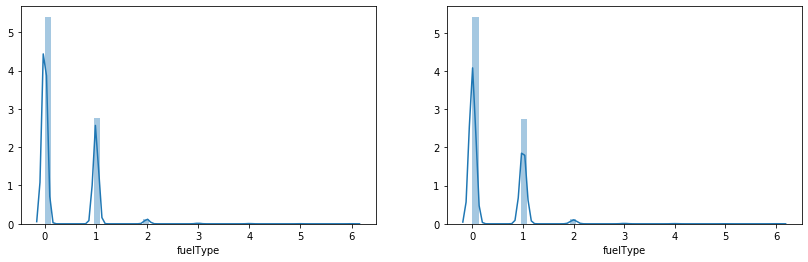

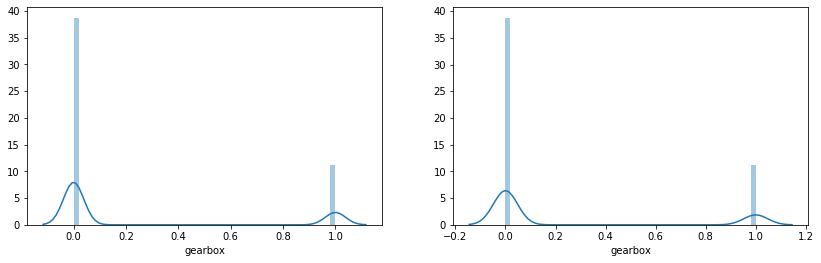

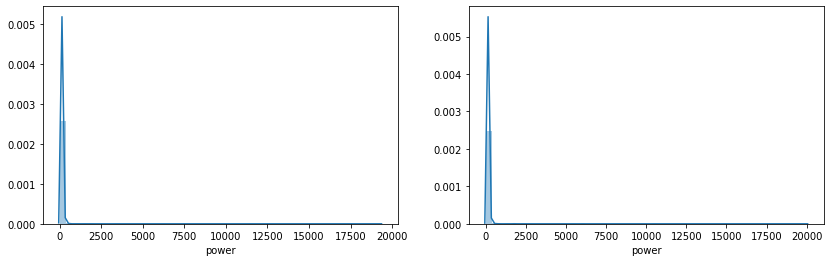

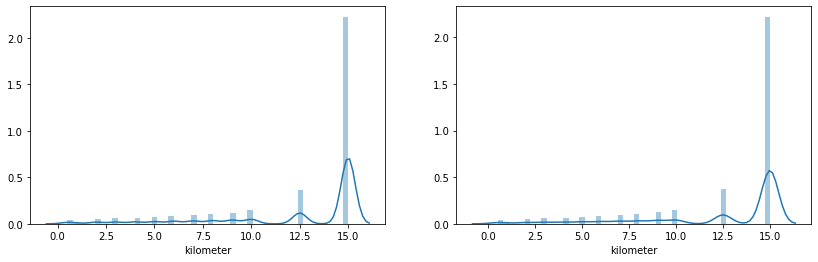

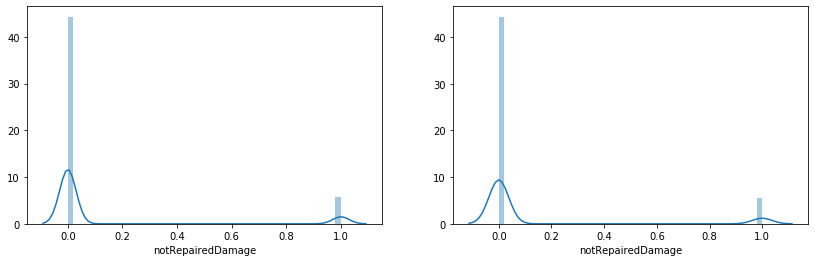

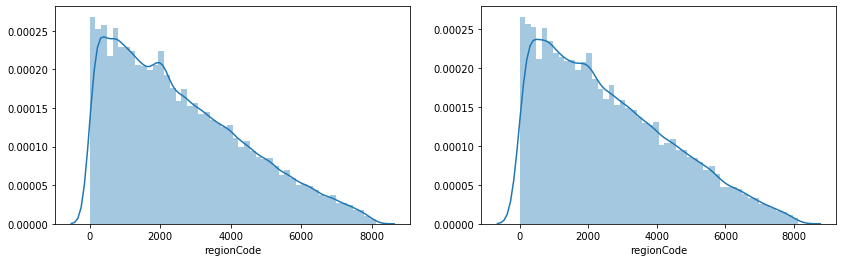

/usr/local/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


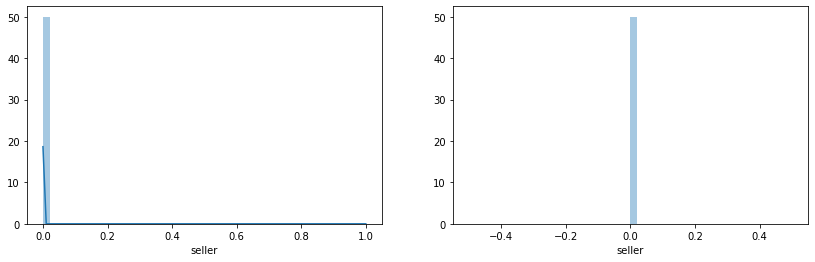

/usr/local/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


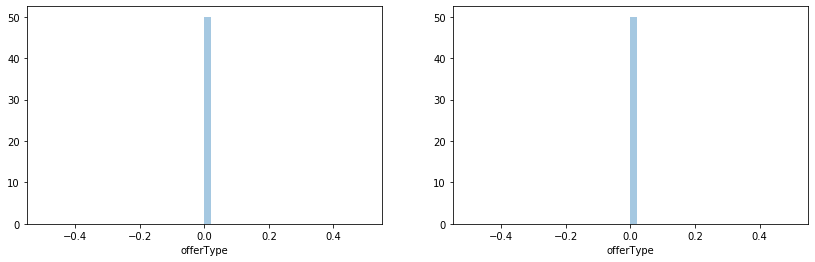

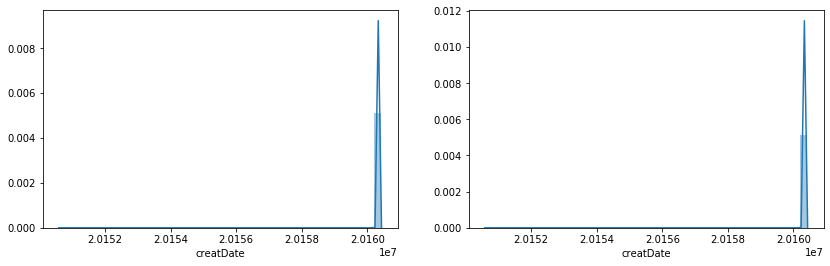

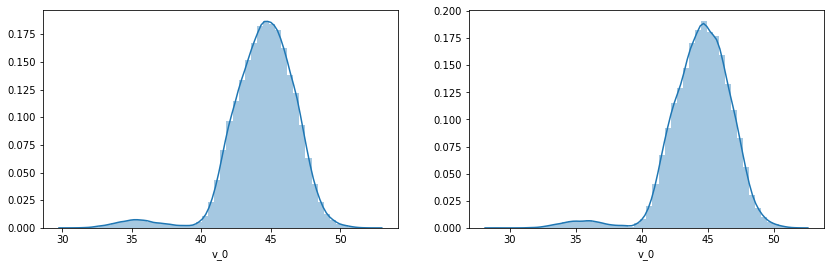

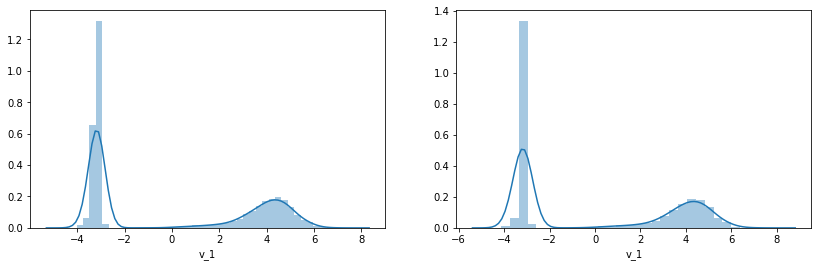

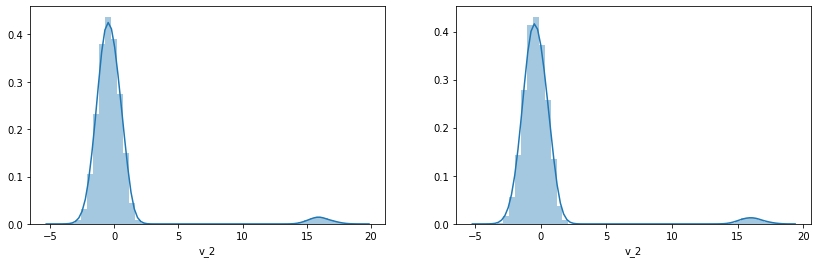

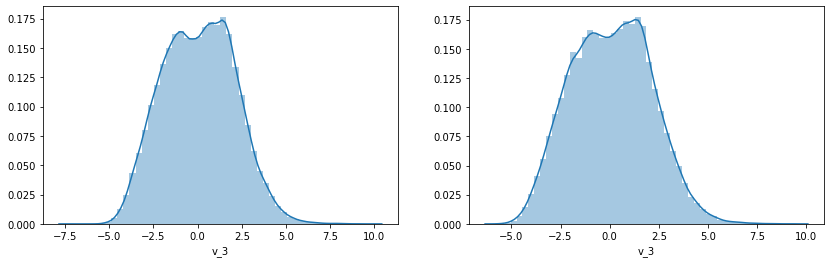

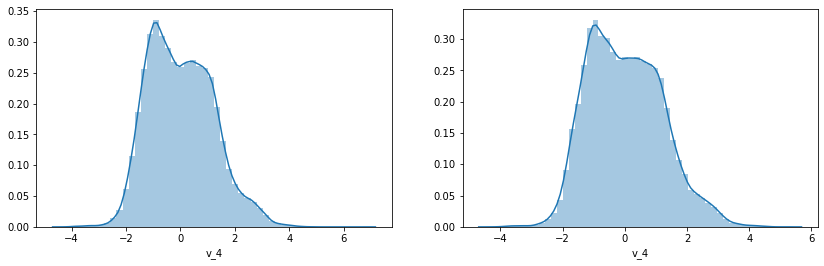

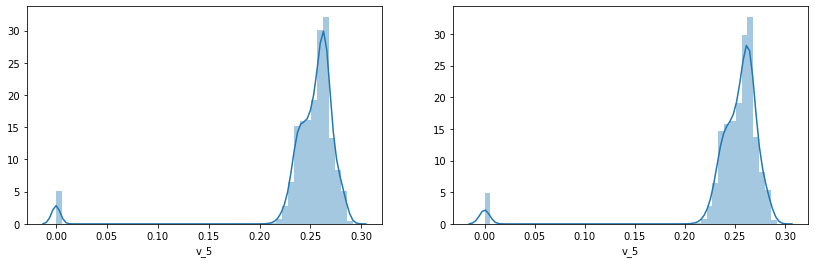

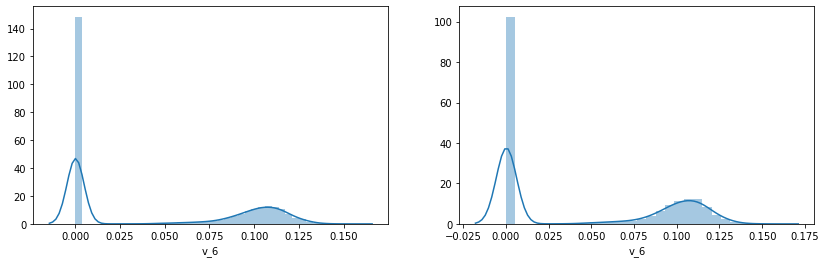

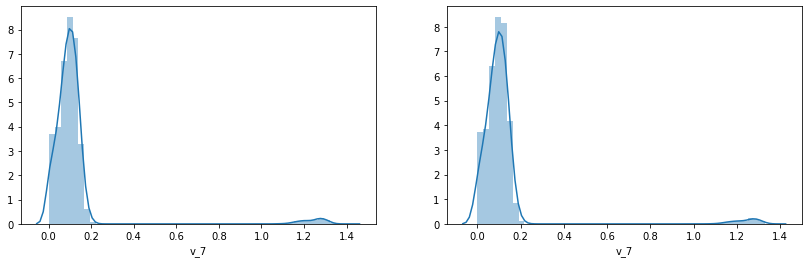

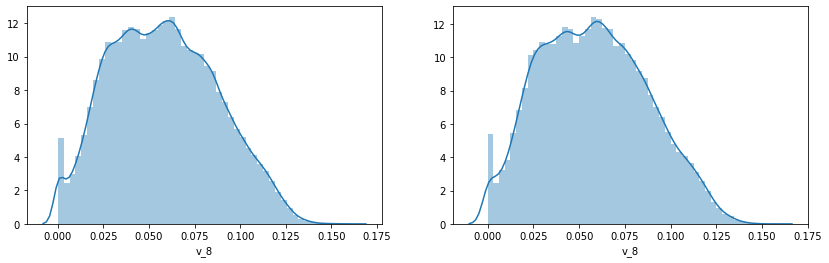

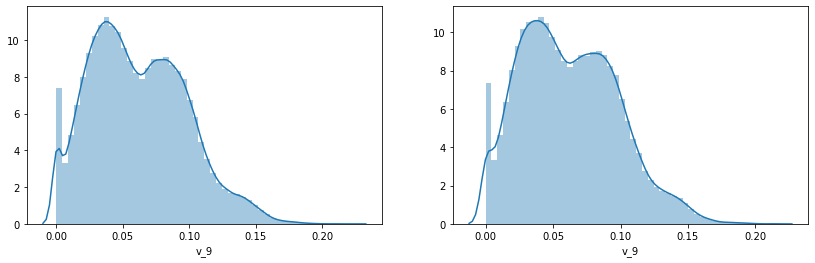

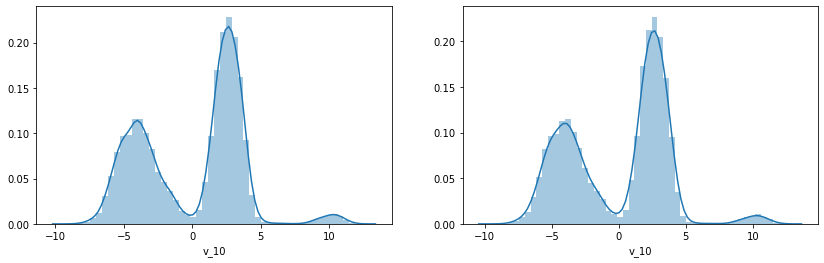

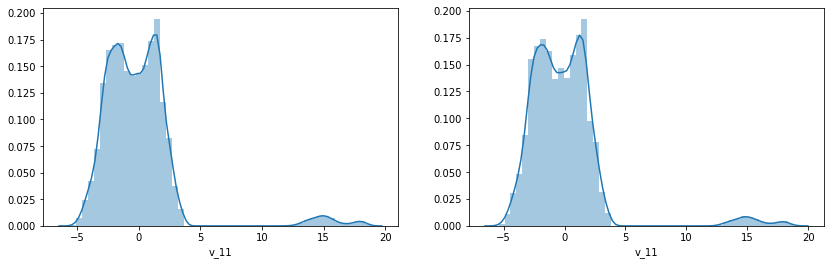

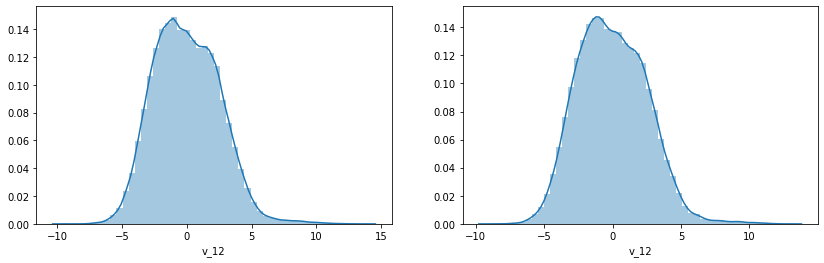

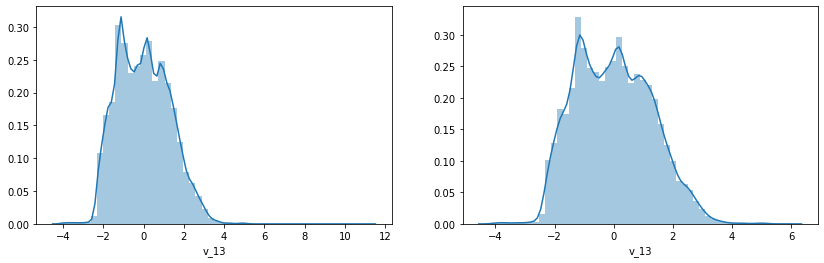

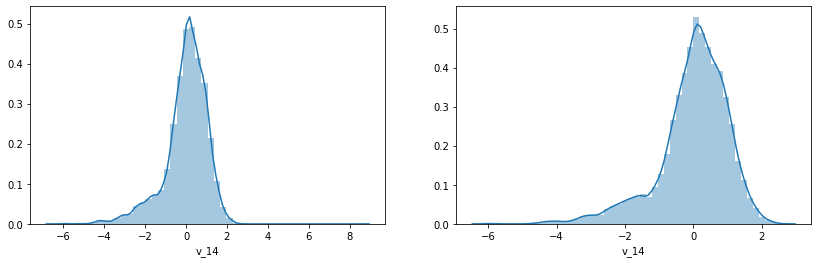

In [28]:
# features distributions compare between train & test sets
for col in data_test.columns:
    figs, axes = plt.subplots(1,2,figsize=(14,4))
    sns.distplot(data[col],ax=axes[0])
    sns.distplot(data_test[col], ax=axes[1])
    plt.show()

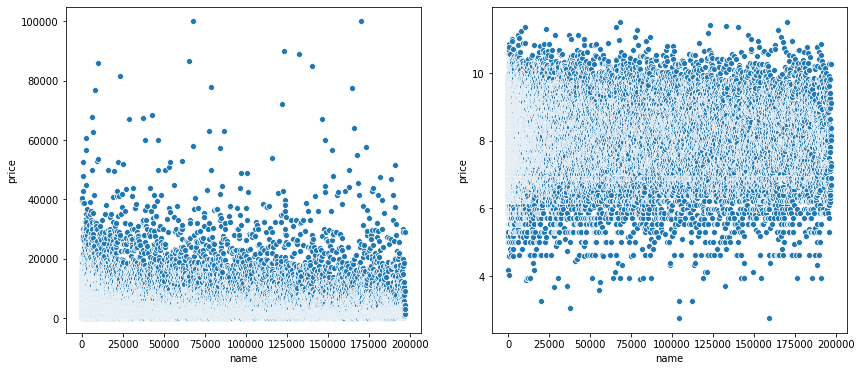

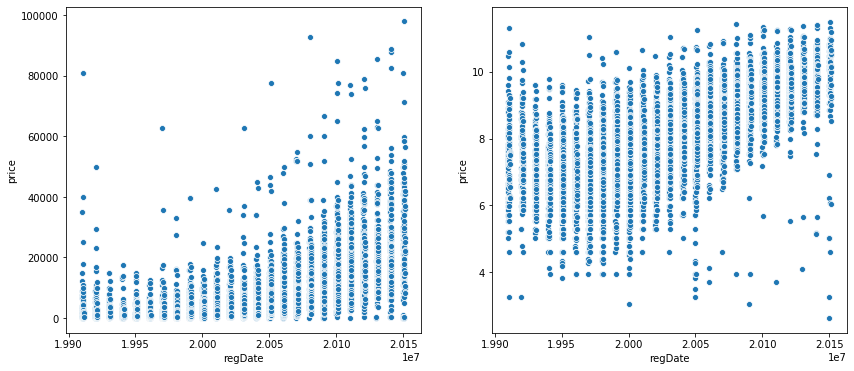

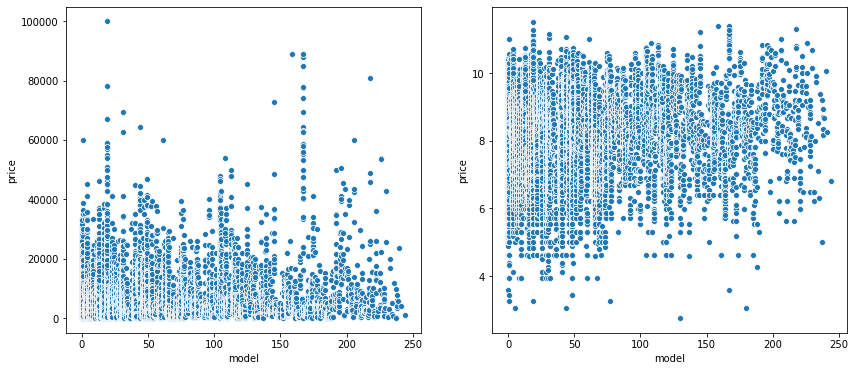

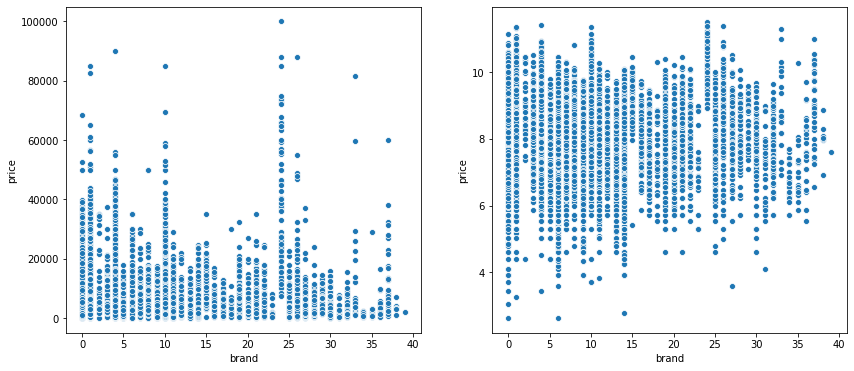

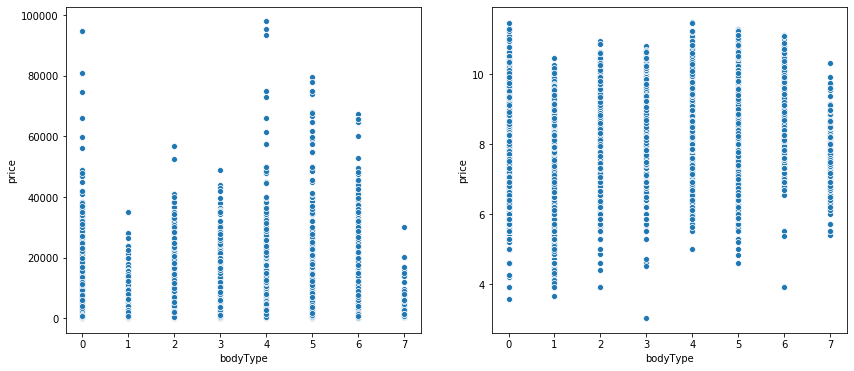

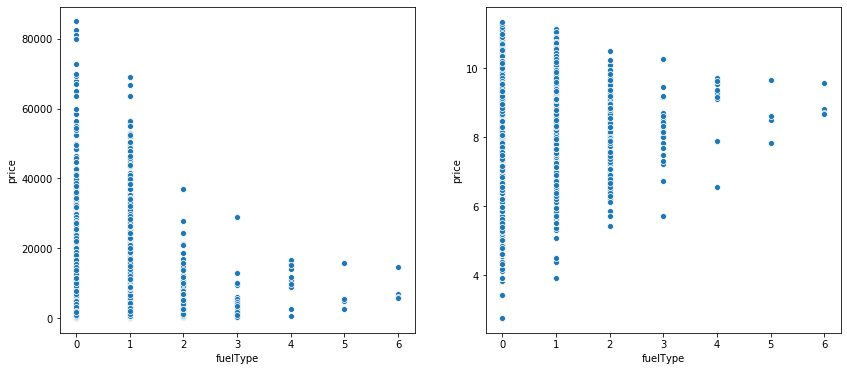

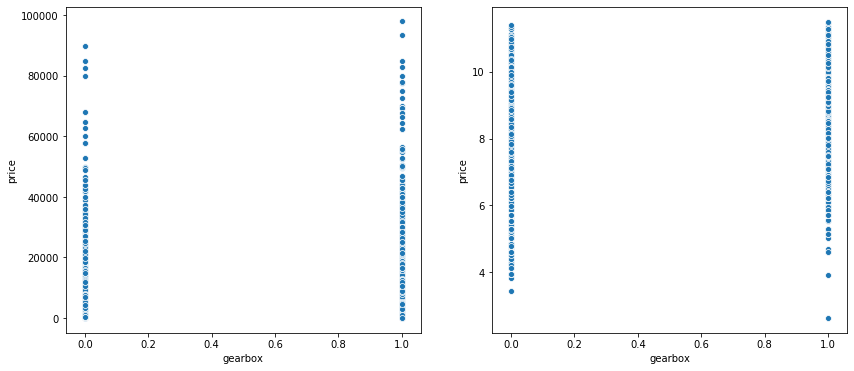

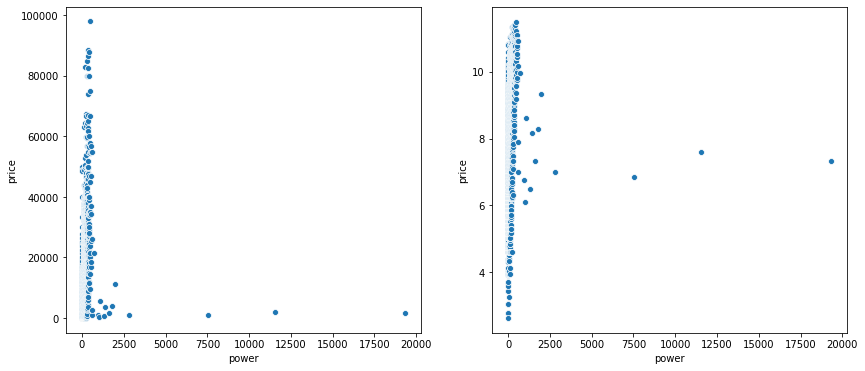

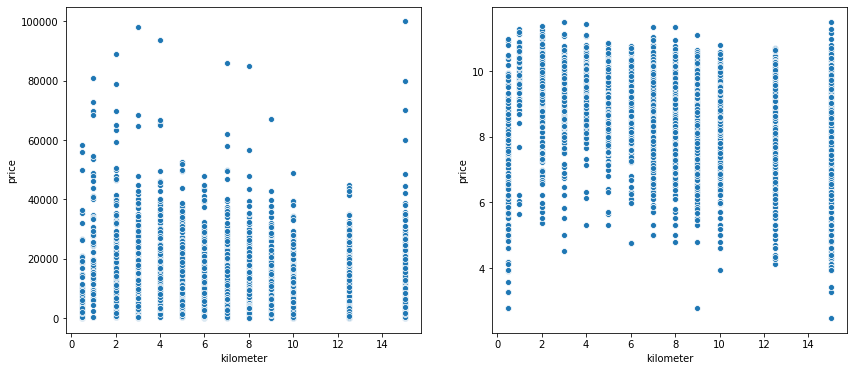

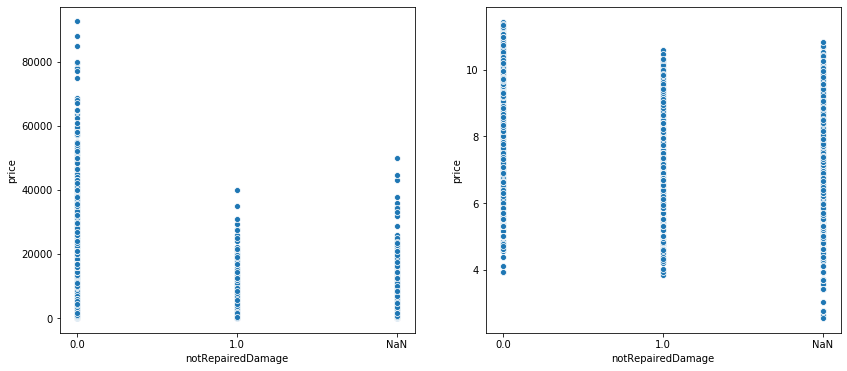

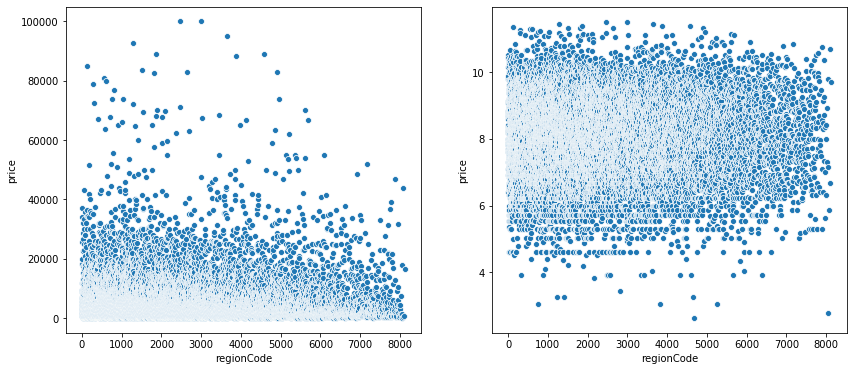

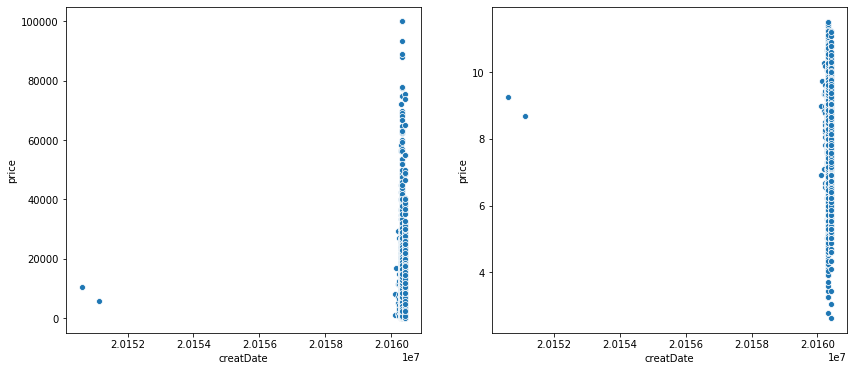

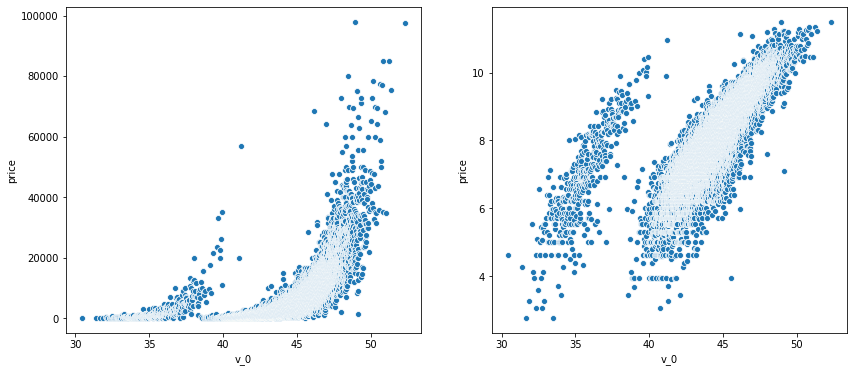

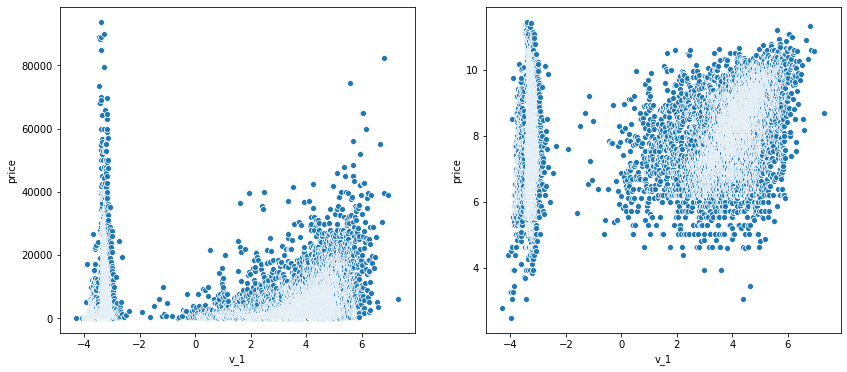

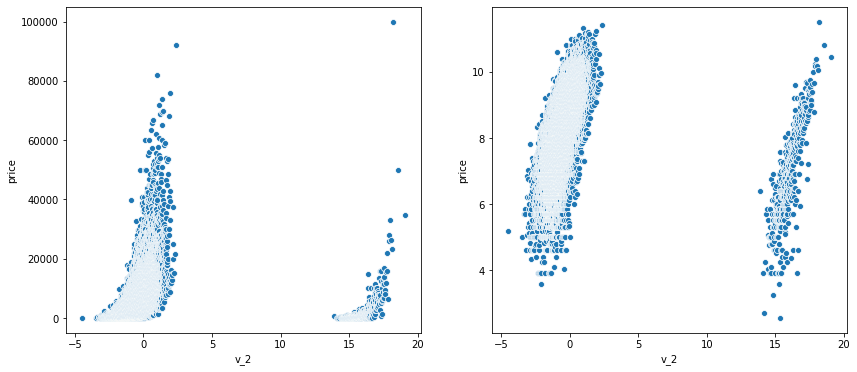

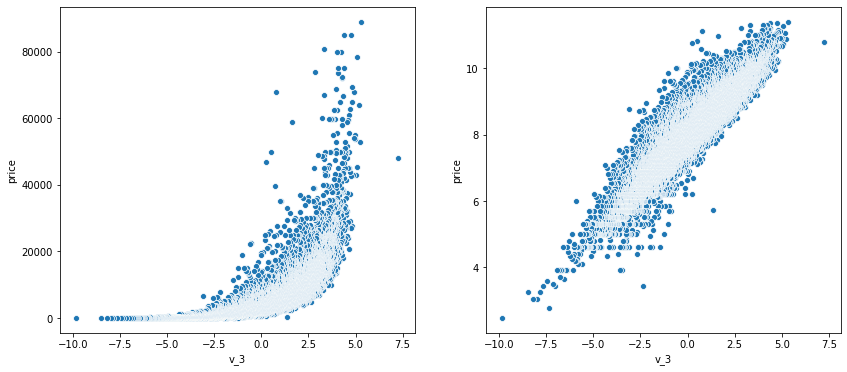

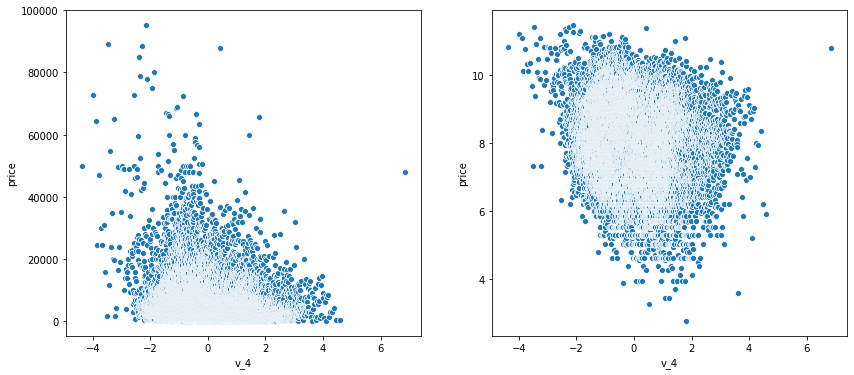

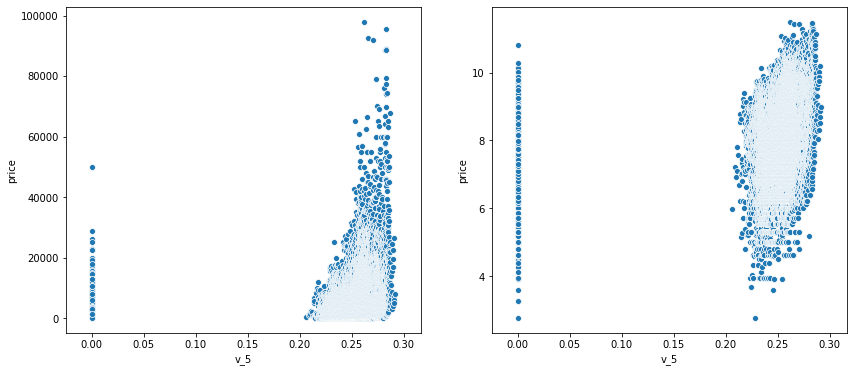

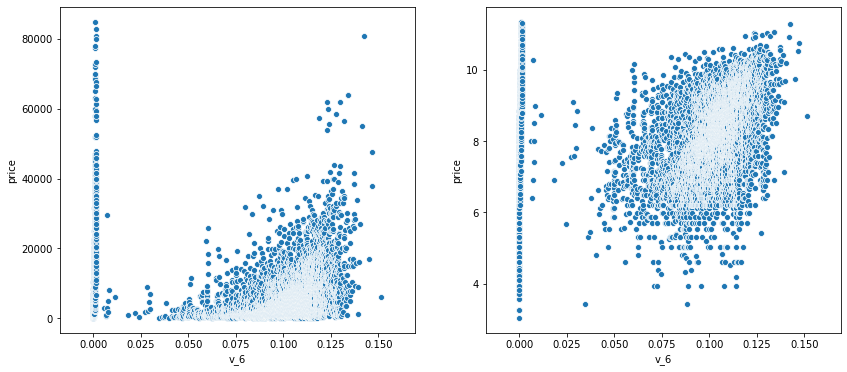

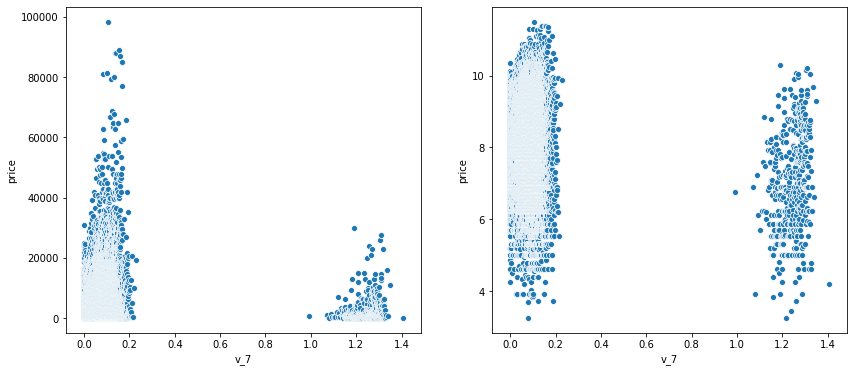

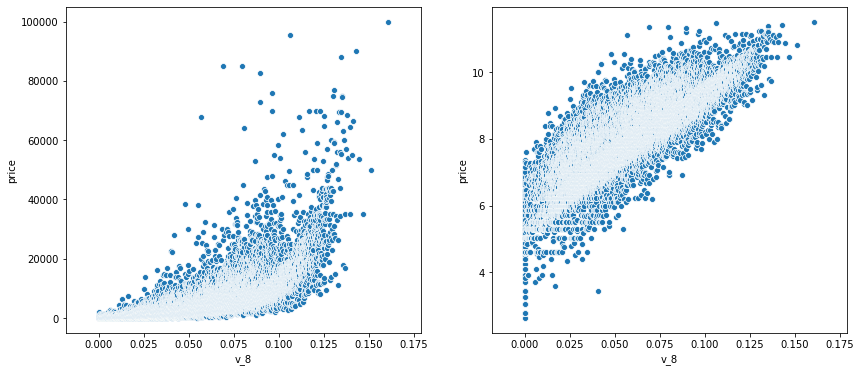

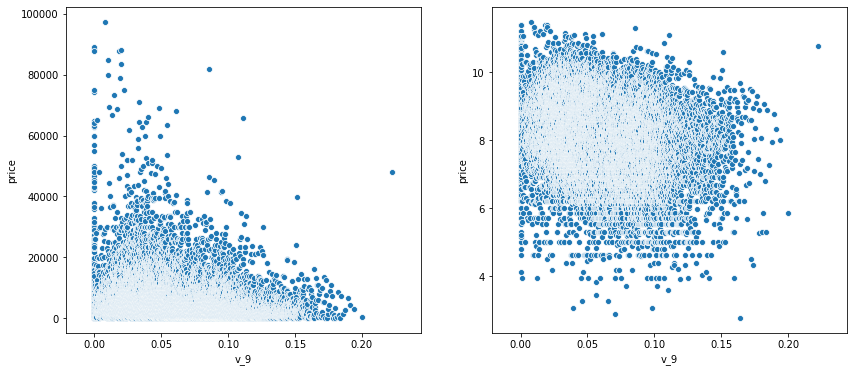

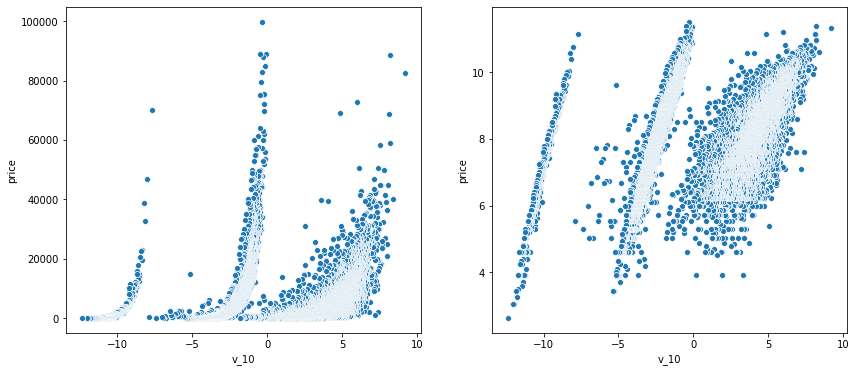

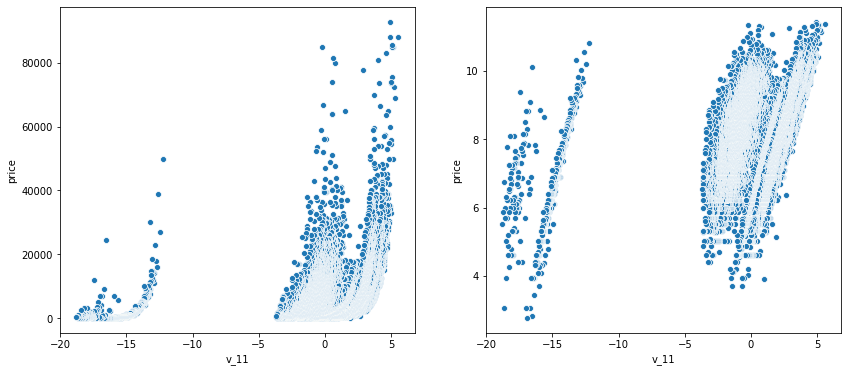

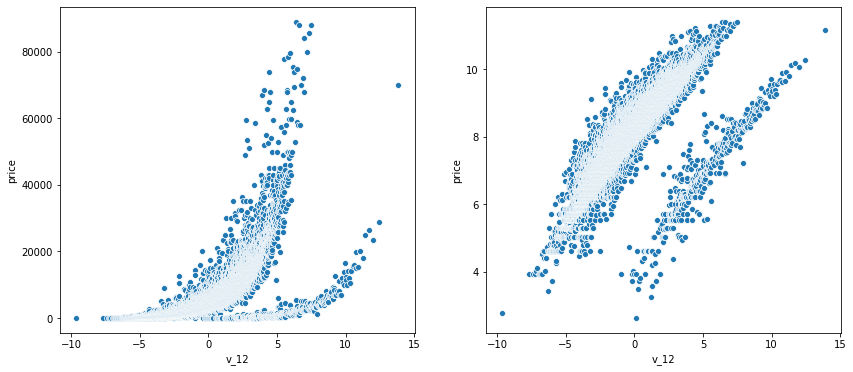

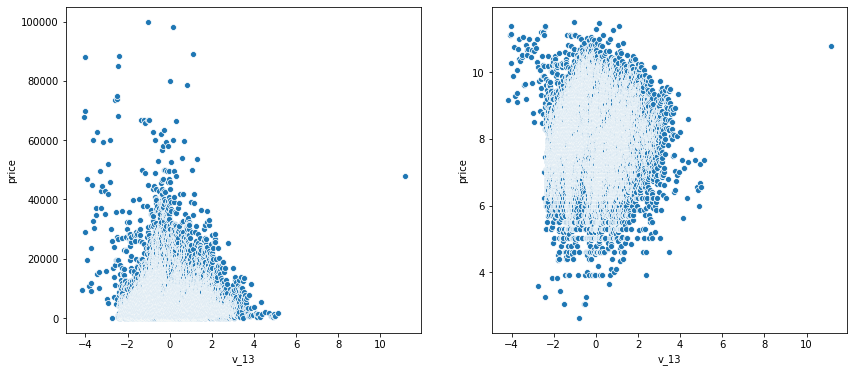

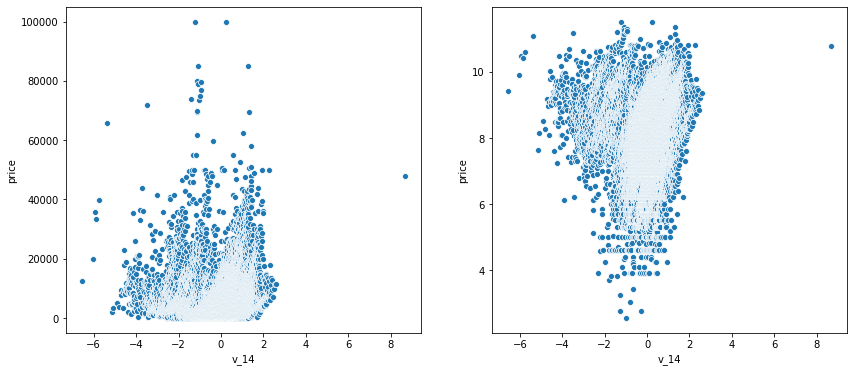

In [58]:

# feature - y corealation sampled 10% of dataset
for k, v in sampled_dict(ft_y_dict).items():
    if k in ['v_3', 'v_10', 'v_11']:
        v[k] = np.negative(v[k])
    if k in drop_cols:
        continue
    figs, axes = plt.subplots(1,2,figsize=(14,6))
    sns.scatterplot(v[k],v['price'],ax=axes[0])
    sns.scatterplot(v[k],np.log1p(v['price']))
    plt.show()

In [127]:
old_selected_cols=['v_12','v_10','regDate','kilometer','v_0','v_14',
               'power','v_8','v_1','v_5','v_3','v_11',
               'v_9','v_6','v_4','notRepairedDamage','model',
               'v_2','v_13','name','brand','v_7','fuelType']
# trash features
drop_cols = ['offerType','seller']
# weak features
drop_v_cols = ['v_1','v_2', 'v_5', 'v_7', 'v_4', 'v_9', 'v_13']
def preprocess(X_train):
    '''
    transform 'notRepairedDamage column from 0, -, 1 to 0,1,2
    return transformed dataset
    '''
    drop_cols = ['offerType', 'seller', ]
    new_col = X_train.notRepairedDamage.map(lambda x: 1 if x == 'NaN' else int(float(x))*2)
    X_train = X_train.drop('notRepairedDamage',axis=1)
    X_train = X_train.join(new_col)
    X_train.drop()
    return X_train

# drop outliers
# v_12 <13
# v_13 <6
# v_14 <4
data = data[(data.v_12<=13)&(data.v_13<=6)&(data.v_14<=4)]
data.drop(drop_cols, axis=1, inplace=True)
data['regDate'] = data.regDate.map(lambda entry: int(str(entry)[0:4]))

In [97]:
%%time
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

def validate(model, X_train, X_valid, y_train, y_valid):
    '''
    return validation scores of training data & validation data
    '''
    preds_valid = model.predict(X_valid)
    preds_train = model.predict(X_train)
    mae_valid = mean_absolute_error(np.exp(preds_valid), np.exp(y_valid))
    mae_train = mean_absolute_error(np.exp(preds_train), np.exp(y_train))
    print("Validation result:")
    print("train set mae on training set is {}".format(mae_train))
    print("valid set mae on validation set is {}".format(mae_valid))

## y->logy
# v_10,11,3->np.negative

#1. drop weak relation features-> train XGB_drop
#2. keep weak relation features-> train XGB_full
#3. perm XGB_full, get selected_cols->train XGB_selected
#4. drop weaks from selected_cols-> train XGB_least

# Note:
# The 'weak' features are mannual selected by myself after looking at charts plotted
# above, so it's more like a intuitive call (though it shows my intuation about selecting
# features are not quiet good, showed by following 2 & 3 model buildings)
# due to this reason, 4th model wasn't built.

# Summary of a basic useful procedure: 

# 1. Simple look over features:
# --- compare feature distributions between train and test sets by sns.displot, barplot or plt.hist
# --- check out feature - y relations by scatter plots as sns.scatterplot, sns.regplot

# 2. Remove outliers
# --- identify outliers by caomparing dist charts between train, test sets
# --- Do NOT remove any feature from scatter plots just because you think it's 'weak'

# 3. Handle missing values, categorical features and date features

# 4. Train

# 5. Feature selection
# --- permutation importance on validation set, get importance chart, drop the last ones
# --- retrain & check validation score better or not

# 6. Tune Hyperparameters
# --- Grid Search or Randomized Grid Search 
# 7. Build final model

#1. 
# Validation result:
# Stopping. Best iteration:
# [1779]	validation_0-mae:0.12164
# train set mae on training set is 351.0736815852463
# valid set mae on validation set is 538.7905334701537
# CPU times: user 15min 9s, sys: 8.57 s, total: 15min 17s
# Wall time: 16min 17s


X_1 = data.copy()

y_1 = np.log1p(X_1['price'])
X_1.drop(drop_v_cols, axis=1, inplace=True)
X_1.drop('price', axis=1, inplace=True)
(X_train_1, X_valid_1,y_train_1, y_valid_1) = train_test_split(X_1, y_1, test_size=0.1)
xgb_model_1 = XGBRegressor(n_estimators=10000, 
                           learning_rate=0.1, 
                           random_state=42, 
                           n_jobs=-1)
xgb_model_1.fit(X_train_1, y_train_1, 
                early_stopping_rounds=42, 
                eval_set=[(X_valid_1, y_valid_1)],
                eval_metric='mae')

# rf_model_1 = RandomForestRegressor(n_estimators=10, criterion='mae', random_state=42, n_jobs=-1)
# rf_model_1.fit(X_train_1, y_train_1)


validate(xgb_model_1, X_train_1, X_valid_1,y_train_1, y_valid_1)
# X_2 = data.copy()
# X_3 = data.copy()
# X_4 = data.copy()

[0]	validation_0-mae:6.79224
Will train until validation_0-mae hasn't improved in 42 rounds.
[1]	validation_0-mae:6.11363
[2]	validation_0-mae:5.50271
[3]	validation_0-mae:4.95318
[4]	validation_0-mae:4.45835
[5]	validation_0-mae:4.01312
[6]	validation_0-mae:3.61246
[7]	validation_0-mae:3.25167
[8]	validation_0-mae:2.92710
[9]	validation_0-mae:2.63501
[10]	validation_0-mae:2.37208
[11]	validation_0-mae:2.13564
[12]	validation_0-mae:1.92284
[13]	validation_0-mae:1.73131
[14]	validation_0-mae:1.55917
[15]	validation_0-mae:1.40448
[16]	validation_0-mae:1.26542
[17]	validation_0-mae:1.14058
[18]	validation_0-mae:1.02875
[19]	validation_0-mae:0.92850
[20]	validation_0-mae:0.83880
[21]	validation_0-mae:0.75856
[22]	validation_0-mae:0.68684
[23]	validation_0-mae:0.62278
[24]	validation_0-mae:0.56573
[25]	validation_0-mae:0.51510
[26]	validation_0-mae:0.46991
[27]	validation_0-mae:0.42978
[28]	validation_0-mae:0.39433
[29]	validation_0-mae:0.36313
[30]	validation_0-mae:0.33521
[31]	validation_

[266]	validation_0-mae:0.13220
[267]	validation_0-mae:0.13218
[268]	validation_0-mae:0.13218
[269]	validation_0-mae:0.13218
[270]	validation_0-mae:0.13215
[271]	validation_0-mae:0.13215
[272]	validation_0-mae:0.13213
[273]	validation_0-mae:0.13207
[274]	validation_0-mae:0.13199
[275]	validation_0-mae:0.13195
[276]	validation_0-mae:0.13191
[277]	validation_0-mae:0.13191
[278]	validation_0-mae:0.13183
[279]	validation_0-mae:0.13179
[280]	validation_0-mae:0.13173
[281]	validation_0-mae:0.13169
[282]	validation_0-mae:0.13167
[283]	validation_0-mae:0.13165
[284]	validation_0-mae:0.13163
[285]	validation_0-mae:0.13162
[286]	validation_0-mae:0.13161
[287]	validation_0-mae:0.13160
[288]	validation_0-mae:0.13160
[289]	validation_0-mae:0.13160
[290]	validation_0-mae:0.13162
[291]	validation_0-mae:0.13161
[292]	validation_0-mae:0.13160
[293]	validation_0-mae:0.13158
[294]	validation_0-mae:0.13158
[295]	validation_0-mae:0.13150
[296]	validation_0-mae:0.13144
[297]	validation_0-mae:0.13134
[298]	va

[531]	validation_0-mae:0.12685
[532]	validation_0-mae:0.12685
[533]	validation_0-mae:0.12684
[534]	validation_0-mae:0.12681
[535]	validation_0-mae:0.12679
[536]	validation_0-mae:0.12674
[537]	validation_0-mae:0.12672
[538]	validation_0-mae:0.12670
[539]	validation_0-mae:0.12669
[540]	validation_0-mae:0.12668
[541]	validation_0-mae:0.12666
[542]	validation_0-mae:0.12665
[543]	validation_0-mae:0.12664
[544]	validation_0-mae:0.12663
[545]	validation_0-mae:0.12661
[546]	validation_0-mae:0.12662
[547]	validation_0-mae:0.12662
[548]	validation_0-mae:0.12662
[549]	validation_0-mae:0.12661
[550]	validation_0-mae:0.12660
[551]	validation_0-mae:0.12659
[552]	validation_0-mae:0.12656
[553]	validation_0-mae:0.12654
[554]	validation_0-mae:0.12656
[555]	validation_0-mae:0.12654
[556]	validation_0-mae:0.12653
[557]	validation_0-mae:0.12654
[558]	validation_0-mae:0.12651
[559]	validation_0-mae:0.12649
[560]	validation_0-mae:0.12650
[561]	validation_0-mae:0.12650
[562]	validation_0-mae:0.12645
[563]	va

[796]	validation_0-mae:0.12430
[797]	validation_0-mae:0.12429
[798]	validation_0-mae:0.12428
[799]	validation_0-mae:0.12429
[800]	validation_0-mae:0.12430
[801]	validation_0-mae:0.12431
[802]	validation_0-mae:0.12433
[803]	validation_0-mae:0.12433
[804]	validation_0-mae:0.12433
[805]	validation_0-mae:0.12434
[806]	validation_0-mae:0.12432
[807]	validation_0-mae:0.12430
[808]	validation_0-mae:0.12429
[809]	validation_0-mae:0.12429
[810]	validation_0-mae:0.12429
[811]	validation_0-mae:0.12430
[812]	validation_0-mae:0.12430
[813]	validation_0-mae:0.12431
[814]	validation_0-mae:0.12430
[815]	validation_0-mae:0.12430
[816]	validation_0-mae:0.12429
[817]	validation_0-mae:0.12429
[818]	validation_0-mae:0.12429
[819]	validation_0-mae:0.12425
[820]	validation_0-mae:0.12426
[821]	validation_0-mae:0.12425
[822]	validation_0-mae:0.12426
[823]	validation_0-mae:0.12426
[824]	validation_0-mae:0.12423
[825]	validation_0-mae:0.12425
[826]	validation_0-mae:0.12423
[827]	validation_0-mae:0.12423
[828]	va

[1059]	validation_0-mae:0.12322
[1060]	validation_0-mae:0.12323
[1061]	validation_0-mae:0.12323
[1062]	validation_0-mae:0.12323
[1063]	validation_0-mae:0.12324
[1064]	validation_0-mae:0.12323
[1065]	validation_0-mae:0.12323
[1066]	validation_0-mae:0.12322
[1067]	validation_0-mae:0.12323
[1068]	validation_0-mae:0.12323
[1069]	validation_0-mae:0.12320
[1070]	validation_0-mae:0.12320
[1071]	validation_0-mae:0.12321
[1072]	validation_0-mae:0.12320
[1073]	validation_0-mae:0.12321
[1074]	validation_0-mae:0.12320
[1075]	validation_0-mae:0.12319
[1076]	validation_0-mae:0.12319
[1077]	validation_0-mae:0.12319
[1078]	validation_0-mae:0.12318
[1079]	validation_0-mae:0.12319
[1080]	validation_0-mae:0.12319
[1081]	validation_0-mae:0.12319
[1082]	validation_0-mae:0.12320
[1083]	validation_0-mae:0.12320
[1084]	validation_0-mae:0.12320
[1085]	validation_0-mae:0.12321
[1086]	validation_0-mae:0.12318
[1087]	validation_0-mae:0.12319
[1088]	validation_0-mae:0.12318
[1089]	validation_0-mae:0.12318
[1090]	v

[1316]	validation_0-mae:0.12263
[1317]	validation_0-mae:0.12263
[1318]	validation_0-mae:0.12262
[1319]	validation_0-mae:0.12263
[1320]	validation_0-mae:0.12263
[1321]	validation_0-mae:0.12263
[1322]	validation_0-mae:0.12264
[1323]	validation_0-mae:0.12264
[1324]	validation_0-mae:0.12264
[1325]	validation_0-mae:0.12264
[1326]	validation_0-mae:0.12264
[1327]	validation_0-mae:0.12265
[1328]	validation_0-mae:0.12265
[1329]	validation_0-mae:0.12264
[1330]	validation_0-mae:0.12263
[1331]	validation_0-mae:0.12263
[1332]	validation_0-mae:0.12263
[1333]	validation_0-mae:0.12264
[1334]	validation_0-mae:0.12263
[1335]	validation_0-mae:0.12264
[1336]	validation_0-mae:0.12264
[1337]	validation_0-mae:0.12262
[1338]	validation_0-mae:0.12262
[1339]	validation_0-mae:0.12262
[1340]	validation_0-mae:0.12263
[1341]	validation_0-mae:0.12264
[1342]	validation_0-mae:0.12264
[1343]	validation_0-mae:0.12264
[1344]	validation_0-mae:0.12263
[1345]	validation_0-mae:0.12264
[1346]	validation_0-mae:0.12264
[1347]	v

[1573]	validation_0-mae:0.12202
[1574]	validation_0-mae:0.12201
[1575]	validation_0-mae:0.12201
[1576]	validation_0-mae:0.12201
[1577]	validation_0-mae:0.12200
[1578]	validation_0-mae:0.12200
[1579]	validation_0-mae:0.12199
[1580]	validation_0-mae:0.12198
[1581]	validation_0-mae:0.12197
[1582]	validation_0-mae:0.12197
[1583]	validation_0-mae:0.12197
[1584]	validation_0-mae:0.12197
[1585]	validation_0-mae:0.12197
[1586]	validation_0-mae:0.12196
[1587]	validation_0-mae:0.12196
[1588]	validation_0-mae:0.12196
[1589]	validation_0-mae:0.12196
[1590]	validation_0-mae:0.12196
[1591]	validation_0-mae:0.12196
[1592]	validation_0-mae:0.12196
[1593]	validation_0-mae:0.12196
[1594]	validation_0-mae:0.12196
[1595]	validation_0-mae:0.12196
[1596]	validation_0-mae:0.12196
[1597]	validation_0-mae:0.12197
[1598]	validation_0-mae:0.12197
[1599]	validation_0-mae:0.12197
[1600]	validation_0-mae:0.12197
[1601]	validation_0-mae:0.12198
[1602]	validation_0-mae:0.12198
[1603]	validation_0-mae:0.12195
[1604]	v

In [104]:
%%time
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

def validate(model, X_train, X_valid, y_train, y_valid):
    '''
    return validation scores of training data & validation data
    '''
    preds_valid = model.predict(X_valid)
    preds_train = model.predict(X_train)
    mae_valid = mean_absolute_error(np.exp(preds_valid), np.exp(y_valid))
    mae_train = mean_absolute_error(np.exp(preds_train), np.exp(y_train))
    print("Validation result:")
    print("train set mae on training set is {}".format(mae_train))
    print("valid set mae on validation set is {}".format(mae_valid))

## y->logy
# v_10,11,3->np.negative

#1. drop weak relation features-> train XGB_drop
#2. keep weak relation features-> train XGB_full
#3. perm XGB_full, get selected_cols->train XGB_selected
#4. drop weaks from selected_cols-> train XGB_least


#2.
# Stopping. Best iteration:
# [2433]	validation_0-mae:0.11861

# Validation result:
# train set mae on training set is 298.07873865494423
# valid set mae on validation set is 524.1959074888865
# CPU times: user 27min 20s, sys: 5.62 s, total: 27min 25s
# Wall time: 28min 3s

# Validation result: (with imputation)
# train set mae on training set is 342.12647505723845
# valid set mae on validation set is 522.3269154717764
# CPU times: user 19min 14s, sys: 4.28 s, total: 19min 19s
# Wall time: 19min 43s
X_2 = data.copy()

y_2 = np.log1p(X_2['price'])
# X_2.drop(drop_v_cols, axis=1, inplace=True)
X_2.drop('price', axis=1, inplace=True)
(X_train_2, X_valid_2,y_train_2, y_valid_2) = train_test_split(X_2, y_2, test_size=0.1)
imputer_2 = SimpleImputer()
X_train_2 = pd.DataFrame(imputer_2.fit_transform(X_train_2))
X_train_2.columns = X_2.columns
X_valid_2 = pd.DataFrame(imputer_2.transform(X_valid_2))
X_valid_2.columns = X_2.columns

xgb_model_2 = XGBRegressor(n_estimators=10000, 
                           learning_rate=0.1, 
                           random_state=42, 
                           n_jobs=-1)
xgb_model_2.fit(X_train_2, y_train_2, 
                early_stopping_rounds=42, 
                eval_set=[(X_valid_2, y_valid_2)],
                eval_metric='mae')


validate(xgb_model_2, X_train_2, X_valid_2,y_train_2, y_valid_2)
# X_3 = data.copy()
# X_4 = data.copy()

[0]	validation_0-mae:6.77708
Will train until validation_0-mae hasn't improved in 42 rounds.
[1]	validation_0-mae:6.09946
[2]	validation_0-mae:5.48937
[3]	validation_0-mae:4.94058
[4]	validation_0-mae:4.44641
[5]	validation_0-mae:4.00174
[6]	validation_0-mae:3.60137
[7]	validation_0-mae:3.24134
[8]	validation_0-mae:2.91726
[9]	validation_0-mae:2.62540
[10]	validation_0-mae:2.36272
[11]	validation_0-mae:2.12652
[12]	validation_0-mae:1.91402
[13]	validation_0-mae:1.72299
[14]	validation_0-mae:1.55118
[15]	validation_0-mae:1.39689
[16]	validation_0-mae:1.25839
[17]	validation_0-mae:1.13414
[18]	validation_0-mae:1.02290
[19]	validation_0-mae:0.92328
[20]	validation_0-mae:0.83404
[21]	validation_0-mae:0.75421
[22]	validation_0-mae:0.68312
[23]	validation_0-mae:0.61971
[24]	validation_0-mae:0.56317
[25]	validation_0-mae:0.51276
[26]	validation_0-mae:0.46804
[27]	validation_0-mae:0.42836
[28]	validation_0-mae:0.39315
[29]	validation_0-mae:0.36206
[30]	validation_0-mae:0.33470
[31]	validation_

[266]	validation_0-mae:0.13231
[267]	validation_0-mae:0.13230
[268]	validation_0-mae:0.13226
[269]	validation_0-mae:0.13225
[270]	validation_0-mae:0.13224
[271]	validation_0-mae:0.13222
[272]	validation_0-mae:0.13222
[273]	validation_0-mae:0.13214
[274]	validation_0-mae:0.13217
[275]	validation_0-mae:0.13217
[276]	validation_0-mae:0.13217
[277]	validation_0-mae:0.13216
[278]	validation_0-mae:0.13208
[279]	validation_0-mae:0.13198
[280]	validation_0-mae:0.13192
[281]	validation_0-mae:0.13191
[282]	validation_0-mae:0.13192
[283]	validation_0-mae:0.13189
[284]	validation_0-mae:0.13189
[285]	validation_0-mae:0.13187
[286]	validation_0-mae:0.13187
[287]	validation_0-mae:0.13185
[288]	validation_0-mae:0.13182
[289]	validation_0-mae:0.13178
[290]	validation_0-mae:0.13165
[291]	validation_0-mae:0.13162
[292]	validation_0-mae:0.13156
[293]	validation_0-mae:0.13151
[294]	validation_0-mae:0.13145
[295]	validation_0-mae:0.13136
[296]	validation_0-mae:0.13133
[297]	validation_0-mae:0.13132
[298]	va

[531]	validation_0-mae:0.12741
[532]	validation_0-mae:0.12740
[533]	validation_0-mae:0.12738
[534]	validation_0-mae:0.12737
[535]	validation_0-mae:0.12733
[536]	validation_0-mae:0.12729
[537]	validation_0-mae:0.12727
[538]	validation_0-mae:0.12727
[539]	validation_0-mae:0.12726
[540]	validation_0-mae:0.12726
[541]	validation_0-mae:0.12725
[542]	validation_0-mae:0.12724
[543]	validation_0-mae:0.12724
[544]	validation_0-mae:0.12724
[545]	validation_0-mae:0.12723
[546]	validation_0-mae:0.12723
[547]	validation_0-mae:0.12723
[548]	validation_0-mae:0.12725
[549]	validation_0-mae:0.12723
[550]	validation_0-mae:0.12722
[551]	validation_0-mae:0.12722
[552]	validation_0-mae:0.12722
[553]	validation_0-mae:0.12721
[554]	validation_0-mae:0.12718
[555]	validation_0-mae:0.12716
[556]	validation_0-mae:0.12716
[557]	validation_0-mae:0.12715
[558]	validation_0-mae:0.12713
[559]	validation_0-mae:0.12712
[560]	validation_0-mae:0.12712
[561]	validation_0-mae:0.12713
[562]	validation_0-mae:0.12713
[563]	va

[796]	validation_0-mae:0.12509
[797]	validation_0-mae:0.12507
[798]	validation_0-mae:0.12505
[799]	validation_0-mae:0.12505
[800]	validation_0-mae:0.12505
[801]	validation_0-mae:0.12504
[802]	validation_0-mae:0.12501
[803]	validation_0-mae:0.12500
[804]	validation_0-mae:0.12500
[805]	validation_0-mae:0.12497
[806]	validation_0-mae:0.12498
[807]	validation_0-mae:0.12496
[808]	validation_0-mae:0.12495
[809]	validation_0-mae:0.12495
[810]	validation_0-mae:0.12493
[811]	validation_0-mae:0.12494
[812]	validation_0-mae:0.12493
[813]	validation_0-mae:0.12492
[814]	validation_0-mae:0.12490
[815]	validation_0-mae:0.12490
[816]	validation_0-mae:0.12489
[817]	validation_0-mae:0.12489
[818]	validation_0-mae:0.12489
[819]	validation_0-mae:0.12489
[820]	validation_0-mae:0.12490
[821]	validation_0-mae:0.12489
[822]	validation_0-mae:0.12488
[823]	validation_0-mae:0.12487
[824]	validation_0-mae:0.12487
[825]	validation_0-mae:0.12483
[826]	validation_0-mae:0.12483
[827]	validation_0-mae:0.12483
[828]	va

[1059]	validation_0-mae:0.12353
[1060]	validation_0-mae:0.12353
[1061]	validation_0-mae:0.12350
[1062]	validation_0-mae:0.12349
[1063]	validation_0-mae:0.12349
[1064]	validation_0-mae:0.12347
[1065]	validation_0-mae:0.12347
[1066]	validation_0-mae:0.12347
[1067]	validation_0-mae:0.12347
[1068]	validation_0-mae:0.12347
[1069]	validation_0-mae:0.12348
[1070]	validation_0-mae:0.12347
[1071]	validation_0-mae:0.12347
[1072]	validation_0-mae:0.12348
[1073]	validation_0-mae:0.12348
[1074]	validation_0-mae:0.12347
[1075]	validation_0-mae:0.12346
[1076]	validation_0-mae:0.12343
[1077]	validation_0-mae:0.12342
[1078]	validation_0-mae:0.12342
[1079]	validation_0-mae:0.12340
[1080]	validation_0-mae:0.12340
[1081]	validation_0-mae:0.12340
[1082]	validation_0-mae:0.12340
[1083]	validation_0-mae:0.12339
[1084]	validation_0-mae:0.12338
[1085]	validation_0-mae:0.12337
[1086]	validation_0-mae:0.12338
[1087]	validation_0-mae:0.12339
[1088]	validation_0-mae:0.12337
[1089]	validation_0-mae:0.12336
[1090]	v

[1316]	validation_0-mae:0.12253
[1317]	validation_0-mae:0.12253
[1318]	validation_0-mae:0.12251
[1319]	validation_0-mae:0.12251
[1320]	validation_0-mae:0.12250
[1321]	validation_0-mae:0.12251
[1322]	validation_0-mae:0.12251
[1323]	validation_0-mae:0.12252
[1324]	validation_0-mae:0.12249
[1325]	validation_0-mae:0.12248
[1326]	validation_0-mae:0.12248
[1327]	validation_0-mae:0.12248
[1328]	validation_0-mae:0.12249
[1329]	validation_0-mae:0.12248
[1330]	validation_0-mae:0.12248
[1331]	validation_0-mae:0.12248
[1332]	validation_0-mae:0.12248
[1333]	validation_0-mae:0.12248
[1334]	validation_0-mae:0.12248
[1335]	validation_0-mae:0.12248
[1336]	validation_0-mae:0.12247
[1337]	validation_0-mae:0.12245
[1338]	validation_0-mae:0.12244
[1339]	validation_0-mae:0.12243
[1340]	validation_0-mae:0.12242
[1341]	validation_0-mae:0.12242
[1342]	validation_0-mae:0.12242
[1343]	validation_0-mae:0.12242
[1344]	validation_0-mae:0.12239
[1345]	validation_0-mae:0.12238
[1346]	validation_0-mae:0.12238
[1347]	v

[1573]	validation_0-mae:0.12158
[1574]	validation_0-mae:0.12158
[1575]	validation_0-mae:0.12158
[1576]	validation_0-mae:0.12158
[1577]	validation_0-mae:0.12158
[1578]	validation_0-mae:0.12158
[1579]	validation_0-mae:0.12158
[1580]	validation_0-mae:0.12158
[1581]	validation_0-mae:0.12157
[1582]	validation_0-mae:0.12158
[1583]	validation_0-mae:0.12156
[1584]	validation_0-mae:0.12156
[1585]	validation_0-mae:0.12156
[1586]	validation_0-mae:0.12155
[1587]	validation_0-mae:0.12155
[1588]	validation_0-mae:0.12155
[1589]	validation_0-mae:0.12155
[1590]	validation_0-mae:0.12153
[1591]	validation_0-mae:0.12153
[1592]	validation_0-mae:0.12153
[1593]	validation_0-mae:0.12152
[1594]	validation_0-mae:0.12152
[1595]	validation_0-mae:0.12153
[1596]	validation_0-mae:0.12153
[1597]	validation_0-mae:0.12154
[1598]	validation_0-mae:0.12155
[1599]	validation_0-mae:0.12154
[1600]	validation_0-mae:0.12155
[1601]	validation_0-mae:0.12155
[1602]	validation_0-mae:0.12155
[1603]	validation_0-mae:0.12155
[1604]	v

[1830]	validation_0-mae:0.12124
[1831]	validation_0-mae:0.12124
[1832]	validation_0-mae:0.12124
[1833]	validation_0-mae:0.12124
[1834]	validation_0-mae:0.12123
[1835]	validation_0-mae:0.12123
[1836]	validation_0-mae:0.12124
[1837]	validation_0-mae:0.12123
[1838]	validation_0-mae:0.12123
[1839]	validation_0-mae:0.12123
[1840]	validation_0-mae:0.12123
[1841]	validation_0-mae:0.12122
[1842]	validation_0-mae:0.12122
[1843]	validation_0-mae:0.12122
[1844]	validation_0-mae:0.12122
[1845]	validation_0-mae:0.12121
[1846]	validation_0-mae:0.12121
[1847]	validation_0-mae:0.12121
Stopping. Best iteration:
[1805]	validation_0-mae:0.12120

Validation result:
train set mae on training set is 342.12647505723845
valid set mae on validation set is 522.3269154717764
CPU times: user 19min 14s, sys: 4.28 s, total: 19min 19s
Wall time: 19min 43s


In [108]:
%%time
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(xgb_model_2, random_state=42).fit(X_valid_2, y_valid_2)
eli5.show_weights(perm, feature_names=X_valid_2.columns.tolist(), top=40)

CPU times: user 6min 34s, sys: 1.04 s, total: 6min 35s
Wall time: 6min 40s


Weight,Feature
0.7320 ± 0.0132,v_3
0.1342 ± 0.0011,v_12
0.1065 ± 0.0011,regDate
0.0696 ± 0.0017,v_0
0.0234 ± 0.0009,v_10
0.0125 ± 0.0009,kilometer
0.0117 ± 0.0012,v_8
0.0114 ± 0.0004,v_6
0.0105 ± 0.0010,power
0.0096 ± 0.0004,v_14


In [130]:
%%time
drop_perm_cols = ['regionCode','creatDate', 'SaleID']

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

def validate(model, X_train, X_valid, y_train, y_valid):
    '''
    return validation scores of training data & validation data
    '''
    preds_valid = model.predict(X_valid)
    preds_train = model.predict(X_train)
    mae_valid = mean_absolute_error(np.exp(preds_valid), np.exp(y_valid))
    mae_train = mean_absolute_error(np.exp(preds_train), np.exp(y_train))
    print("Validation result:")
    print("train set mae on training set is {}".format(mae_train))
    print("valid set mae on validation set is {}".format(mae_valid))

## y->logy
# v_10,11,3->np.negative

#1. drop weak relation features-> train XGB_drop
#2. keep weak relation features-> train XGB_full
#3. perm XGB_full, get selected_cols->train XGB_selected
#4. drop weaks from selected_cols-> train XGB_least


#3. 
X_3 = data.copy()
y_3 = np.log1p(X_3['price'])
X_3.drop('price', axis=1, inplace=True)
X_3.drop(drop_perm_cols, inplace=True, axis=1)
(X_train_3, X_valid_3,y_train_3, y_valid_3) = train_test_split(X_3, y_3, test_size=0.1)
imputer_3 = SimpleImputer()
X_train_3 = pd.DataFrame(imputer_3.fit_transform(X_train_3))
X_train_3.columns = X_3.columns
X_valid_3 = pd.DataFrame(imputer_3.transform(X_valid_3))
X_valid_3.columns = X_3.columns

xgb_model_3 = XGBRegressor(n_estimators=10000, 
                           learning_rate=0.1, 
                           random_state=42, 
                           n_jobs=-1)
xgb_model_3.fit(X_train_3, y_train_3, 
                early_stopping_rounds=42, 
                eval_set=[(X_valid_3, y_valid_3)],
                eval_metric='mae')


validate(xgb_model_3, X_train_3, X_valid_3,y_train_3, y_valid_3)
# X_3 = data.copy()
# X_4 = data.copy()

[0]	validation_0-mae:6.86316
Will train until validation_0-mae hasn't improved in 42 rounds.
[1]	validation_0-mae:6.24578
[2]	validation_0-mae:5.68389
[3]	validation_0-mae:5.17275
[4]	validation_0-mae:4.70738
[5]	validation_0-mae:4.28397
[6]	validation_0-mae:3.89865
[7]	validation_0-mae:3.54802
[8]	validation_0-mae:3.22906
[9]	validation_0-mae:2.93868
[10]	validation_0-mae:2.67454
[11]	validation_0-mae:2.43409
[12]	validation_0-mae:2.21544
[13]	validation_0-mae:2.01659
[14]	validation_0-mae:1.83571
[15]	validation_0-mae:1.67149
[16]	validation_0-mae:1.52221
[17]	validation_0-mae:1.38650
[18]	validation_0-mae:1.26323
[19]	validation_0-mae:1.15109
[20]	validation_0-mae:1.04939
[21]	validation_0-mae:0.95701
[22]	validation_0-mae:0.87341
[23]	validation_0-mae:0.79779
[24]	validation_0-mae:0.72939
[25]	validation_0-mae:0.66767
[26]	validation_0-mae:0.61208
[27]	validation_0-mae:0.56199
[28]	validation_0-mae:0.51670
[29]	validation_0-mae:0.47578
[30]	validation_0-mae:0.43909
[31]	validation_

[266]	validation_0-mae:0.13072
[267]	validation_0-mae:0.13070
[268]	validation_0-mae:0.13068
[269]	validation_0-mae:0.13067
[270]	validation_0-mae:0.13066
[271]	validation_0-mae:0.13066
[272]	validation_0-mae:0.13064
[273]	validation_0-mae:0.13063
[274]	validation_0-mae:0.13062
[275]	validation_0-mae:0.13049
[276]	validation_0-mae:0.13043
[277]	validation_0-mae:0.13040
[278]	validation_0-mae:0.13040
[279]	validation_0-mae:0.13040
[280]	validation_0-mae:0.13040
[281]	validation_0-mae:0.13038
[282]	validation_0-mae:0.13038
[283]	validation_0-mae:0.13034
[284]	validation_0-mae:0.13023
[285]	validation_0-mae:0.13022
[286]	validation_0-mae:0.13021
[287]	validation_0-mae:0.13017
[288]	validation_0-mae:0.13017
[289]	validation_0-mae:0.13017
[290]	validation_0-mae:0.13013
[291]	validation_0-mae:0.13007
[292]	validation_0-mae:0.13007
[293]	validation_0-mae:0.12996
[294]	validation_0-mae:0.12991
[295]	validation_0-mae:0.12986
[296]	validation_0-mae:0.12985
[297]	validation_0-mae:0.12983
[298]	va

[531]	validation_0-mae:0.12571
[532]	validation_0-mae:0.12569
[533]	validation_0-mae:0.12569
[534]	validation_0-mae:0.12569
[535]	validation_0-mae:0.12559
[536]	validation_0-mae:0.12559
[537]	validation_0-mae:0.12558
[538]	validation_0-mae:0.12559
[539]	validation_0-mae:0.12553
[540]	validation_0-mae:0.12552
[541]	validation_0-mae:0.12552
[542]	validation_0-mae:0.12550
[543]	validation_0-mae:0.12548
[544]	validation_0-mae:0.12547
[545]	validation_0-mae:0.12547
[546]	validation_0-mae:0.12544
[547]	validation_0-mae:0.12543
[548]	validation_0-mae:0.12543
[549]	validation_0-mae:0.12543
[550]	validation_0-mae:0.12542
[551]	validation_0-mae:0.12539
[552]	validation_0-mae:0.12538
[553]	validation_0-mae:0.12539
[554]	validation_0-mae:0.12538
[555]	validation_0-mae:0.12535
[556]	validation_0-mae:0.12532
[557]	validation_0-mae:0.12533
[558]	validation_0-mae:0.12532
[559]	validation_0-mae:0.12532
[560]	validation_0-mae:0.12534
[561]	validation_0-mae:0.12534
[562]	validation_0-mae:0.12533
[563]	va

[796]	validation_0-mae:0.12314
[797]	validation_0-mae:0.12310
[798]	validation_0-mae:0.12310
[799]	validation_0-mae:0.12310
[800]	validation_0-mae:0.12309
[801]	validation_0-mae:0.12308
[802]	validation_0-mae:0.12308
[803]	validation_0-mae:0.12308
[804]	validation_0-mae:0.12307
[805]	validation_0-mae:0.12302
[806]	validation_0-mae:0.12302
[807]	validation_0-mae:0.12302
[808]	validation_0-mae:0.12302
[809]	validation_0-mae:0.12299
[810]	validation_0-mae:0.12298
[811]	validation_0-mae:0.12297
[812]	validation_0-mae:0.12295
[813]	validation_0-mae:0.12294
[814]	validation_0-mae:0.12292
[815]	validation_0-mae:0.12292
[816]	validation_0-mae:0.12294
[817]	validation_0-mae:0.12293
[818]	validation_0-mae:0.12291
[819]	validation_0-mae:0.12291
[820]	validation_0-mae:0.12291
[821]	validation_0-mae:0.12285
[822]	validation_0-mae:0.12284
[823]	validation_0-mae:0.12283
[824]	validation_0-mae:0.12284
[825]	validation_0-mae:0.12283
[826]	validation_0-mae:0.12283
[827]	validation_0-mae:0.12283
[828]	va

[1059]	validation_0-mae:0.12154
[1060]	validation_0-mae:0.12152
[1061]	validation_0-mae:0.12149
[1062]	validation_0-mae:0.12149
[1063]	validation_0-mae:0.12149
[1064]	validation_0-mae:0.12149
[1065]	validation_0-mae:0.12149
[1066]	validation_0-mae:0.12149
[1067]	validation_0-mae:0.12149
[1068]	validation_0-mae:0.12149
[1069]	validation_0-mae:0.12149
[1070]	validation_0-mae:0.12150
[1071]	validation_0-mae:0.12150
[1072]	validation_0-mae:0.12149
[1073]	validation_0-mae:0.12150
[1074]	validation_0-mae:0.12151
[1075]	validation_0-mae:0.12149
[1076]	validation_0-mae:0.12149
[1077]	validation_0-mae:0.12148
[1078]	validation_0-mae:0.12148
[1079]	validation_0-mae:0.12150
[1080]	validation_0-mae:0.12150
[1081]	validation_0-mae:0.12150
[1082]	validation_0-mae:0.12150
[1083]	validation_0-mae:0.12151
[1084]	validation_0-mae:0.12149
[1085]	validation_0-mae:0.12148
[1086]	validation_0-mae:0.12149
[1087]	validation_0-mae:0.12149
[1088]	validation_0-mae:0.12149
[1089]	validation_0-mae:0.12148
[1090]	v

[1316]	validation_0-mae:0.12059
[1317]	validation_0-mae:0.12059
[1318]	validation_0-mae:0.12059
[1319]	validation_0-mae:0.12060
[1320]	validation_0-mae:0.12060
[1321]	validation_0-mae:0.12058
[1322]	validation_0-mae:0.12058
[1323]	validation_0-mae:0.12058
[1324]	validation_0-mae:0.12057
[1325]	validation_0-mae:0.12057
[1326]	validation_0-mae:0.12057
[1327]	validation_0-mae:0.12056
[1328]	validation_0-mae:0.12055
[1329]	validation_0-mae:0.12055
[1330]	validation_0-mae:0.12055
[1331]	validation_0-mae:0.12055
[1332]	validation_0-mae:0.12055
[1333]	validation_0-mae:0.12055
[1334]	validation_0-mae:0.12055
[1335]	validation_0-mae:0.12054
[1336]	validation_0-mae:0.12053
[1337]	validation_0-mae:0.12052
[1338]	validation_0-mae:0.12051
[1339]	validation_0-mae:0.12051
[1340]	validation_0-mae:0.12050
[1341]	validation_0-mae:0.12051
[1342]	validation_0-mae:0.12049
[1343]	validation_0-mae:0.12050
[1344]	validation_0-mae:0.12050
[1345]	validation_0-mae:0.12047
[1346]	validation_0-mae:0.12047
[1347]	v

[1573]	validation_0-mae:0.11993
[1574]	validation_0-mae:0.11993
[1575]	validation_0-mae:0.11991
[1576]	validation_0-mae:0.11990
[1577]	validation_0-mae:0.11990
[1578]	validation_0-mae:0.11989
[1579]	validation_0-mae:0.11988
[1580]	validation_0-mae:0.11989
[1581]	validation_0-mae:0.11989
[1582]	validation_0-mae:0.11989
[1583]	validation_0-mae:0.11989
[1584]	validation_0-mae:0.11987
[1585]	validation_0-mae:0.11986
[1586]	validation_0-mae:0.11987
[1587]	validation_0-mae:0.11985
[1588]	validation_0-mae:0.11986
[1589]	validation_0-mae:0.11986
[1590]	validation_0-mae:0.11985
[1591]	validation_0-mae:0.11986
[1592]	validation_0-mae:0.11986
[1593]	validation_0-mae:0.11984
[1594]	validation_0-mae:0.11985
[1595]	validation_0-mae:0.11985
[1596]	validation_0-mae:0.11984
[1597]	validation_0-mae:0.11983
[1598]	validation_0-mae:0.11983
[1599]	validation_0-mae:0.11983
[1600]	validation_0-mae:0.11983
[1601]	validation_0-mae:0.11982
[1602]	validation_0-mae:0.11981
[1603]	validation_0-mae:0.11981
[1604]	v

[1830]	validation_0-mae:0.11944
[1831]	validation_0-mae:0.11944
[1832]	validation_0-mae:0.11944
[1833]	validation_0-mae:0.11944
[1834]	validation_0-mae:0.11945
[1835]	validation_0-mae:0.11945
[1836]	validation_0-mae:0.11943
[1837]	validation_0-mae:0.11943
[1838]	validation_0-mae:0.11943
[1839]	validation_0-mae:0.11942
[1840]	validation_0-mae:0.11942
[1841]	validation_0-mae:0.11941
[1842]	validation_0-mae:0.11940
[1843]	validation_0-mae:0.11940
[1844]	validation_0-mae:0.11941
[1845]	validation_0-mae:0.11941
[1846]	validation_0-mae:0.11941
[1847]	validation_0-mae:0.11942
[1848]	validation_0-mae:0.11942
[1849]	validation_0-mae:0.11941
[1850]	validation_0-mae:0.11942
[1851]	validation_0-mae:0.11942
[1852]	validation_0-mae:0.11943
[1853]	validation_0-mae:0.11943
[1854]	validation_0-mae:0.11943
[1855]	validation_0-mae:0.11943
[1856]	validation_0-mae:0.11942
[1857]	validation_0-mae:0.11941
[1858]	validation_0-mae:0.11942
[1859]	validation_0-mae:0.11942
[1860]	validation_0-mae:0.11942
[1861]	v

[2087]	validation_0-mae:0.11905
[2088]	validation_0-mae:0.11905
[2089]	validation_0-mae:0.11905
[2090]	validation_0-mae:0.11905
[2091]	validation_0-mae:0.11905
[2092]	validation_0-mae:0.11906
[2093]	validation_0-mae:0.11906
[2094]	validation_0-mae:0.11906
[2095]	validation_0-mae:0.11906
[2096]	validation_0-mae:0.11907
[2097]	validation_0-mae:0.11907
[2098]	validation_0-mae:0.11907
[2099]	validation_0-mae:0.11907
[2100]	validation_0-mae:0.11908
[2101]	validation_0-mae:0.11908
[2102]	validation_0-mae:0.11908
[2103]	validation_0-mae:0.11908
[2104]	validation_0-mae:0.11908
[2105]	validation_0-mae:0.11909
[2106]	validation_0-mae:0.11909
[2107]	validation_0-mae:0.11910
[2108]	validation_0-mae:0.11910
[2109]	validation_0-mae:0.11910
[2110]	validation_0-mae:0.11910
[2111]	validation_0-mae:0.11909
[2112]	validation_0-mae:0.11910
[2113]	validation_0-mae:0.11909
[2114]	validation_0-mae:0.11909
[2115]	validation_0-mae:0.11909
[2116]	validation_0-mae:0.11909
[2117]	validation_0-mae:0.11909
[2118]	v

In [124]:
%%time
#estimator outputs
saleId = data_test.SaleID
X_test = data_test

drop_cols = ['offerType', 'seller', 'regionCode','creatDate', 'SaleID']

X_test.drop(drop_cols, inplace=True, axis=1)  
X_test['regDate'] = X_test.regDate.map(lambda entry: int(str(entry)[0:4]))

cols = X_test.columns
X_test = pd.DataFrame(imputer_3.transform(X_test))
X_test.columns = cols

preds = xgb_model_3.predict(X_test)
res = pd.DataFrame({'SaleID':saleId, 'price':np.exp(preds)})
res.to_csv('xgb_submission_perm_valid.csv', index=False)


CPU times: user 10.3 s, sys: 117 ms, total: 10.4 s
Wall time: 11.1 s


In [128]:
%%time
#final train
saleId = data_test.SaleID
X_test = data_test

drop_cols = ['offerType', 'seller', 'regionCode','creatDate', 'SaleID']

final_imputer = SimpleImputer()
cols = X_3.columns
X_3 = pd.DataFrame(final_imputer.fit_transform(X_3))
X_3.columns = cols

X_test.drop(drop_cols, inplace=True, axis=1)  
X_test['regDate'] = X_test.regDate.map(lambda entry: int(str(entry)[0:4]))

cols = X_test.columns
X_test = pd.DataFrame(final_imputer.transform(X_test))
X_test.columns = cols

xgb_model_final = XGBRegressor(n_estimators=1800, 
                           learning_rate=0.1, 
                           random_state=42, 
                           n_jobs=-1)

xgb_model_final.fit(X_3, y_3)
preds = xgb_model_final.predict(X_test)
res = pd.DataFrame({'SaleID':saleId, 'price':np.exp(preds)})
res.to_csv('xgb_submission_perm.csv', index=False)


CPU times: user 19min 30s, sys: 5.51 s, total: 19min 36s
Wall time: 20min 23s
